In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import joblib
import os

import lightgbm as lgbm

1. trimming the raw dataset on week: sales, calender, prices
    - trimming pipeline: small for debug, mid for evaluation, whole
2. preprocess
    - after trimming
    - new features from internal or external?
    - -8 to +8?
3. training
4. predict

4 notebooks: 4 kedro pipelines

In [2]:
sns.set_theme()
plt.rcParams["figure.figsize"] = (16,8)

In [3]:
key_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'date']
LAGS = [1,2,3,6,12,24,36]
WINDOWS = [7,30,90,180,365]
ENABLE_ROLLING_MIN_PERIOD = True

# Preprocess

In [4]:
# utils

def print_memory_usage(df):
    print(f"df memory usage: {np.round(df.memory_usage().sum()/(1024*1024),1)}mb")
    return None

#Downcast in order to save memory
def downcast(df):
    print('Before downcasting:')
    print_memory_usage(df)
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                if t!=np.int8:
                    df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                if t!=np.int16:
                    df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                if t!=np.int32:
                    df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                if t!=np.int64:
                    df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                if t!=np.float16:
                    df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                if t!=np.float32:
                    df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                if t!=np.float64:
                    df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == 'object':
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                if t!='category':
                    df[cols[i]] = df[cols[i]].astype('category')
    print('After downcasting:')
    print_memory_usage(df)
    return df

def show_trimming_result(df_be, df_af):
    df_be = df_be.loc[:, 'sell_price':].isnull().sum().reset_index().rename(columns={'index': 'col', 0: 'null_cnt_before'})
    df_af = df_af.loc[:, 'sell_price':].isnull().sum().reset_index().rename(columns={'index': 'col', 0: 'null_cnt_after'})
    df = pd.concat([df_be, df_af.null_cnt_after], axis=1)
    return df

In [30]:
sales = pd.read_csv('./data/sales_train_evaluation.csv')
calendar = pd.read_csv('./data/calendar.csv')
prices = pd.read_csv('./data/sell_prices.csv')

# trim on sales to fasten the process
# sales = sales[sales.state_id == "CA"]

In [37]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [6]:
# preprocess on calendar
calendar['holiday'] = calendar['event_name_1'].notnull() | calendar['event_name_2'].notnull()
calendar = calendar[['date', 'wm_yr_wk', 'weekday', 'month', 'year', 'd', 'holiday']]
calendar

,date,wm_yr_wk,weekday,month,year,d,holiday
0,2011-01-29,11101,Saturday,1,2011,d_1,False
1,2011-01-30,11101,Sunday,1,2011,d_2,False
2,2011-01-31,11101,Monday,1,2011,d_3,False
3,2011-02-01,11101,Tuesday,2,2011,d_4,False
4,2011-02-02,11101,Wednesday,2,2011,d_5,False
...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,6,2016,d_1965,False
1965,2016-06-16,11620,Thursday,6,2016,d_1966,False
1966,2016-06-17,11620,Friday,6,2016,d_1967,False
1967,2016-06-18,11621,Saturday,6,2016,d_1968,False


In [7]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [8]:
sales = downcast(sales)
calendar = downcast(calendar)
prices = downcast(prices)

Before downcasting:
df memory usage: 454.5mb
After downcasting:
df memory usage: 97.1mb
Before downcasting:
df memory usage: 0.1mb
After downcasting:
df memory usage: 0.1mb
Before downcasting:
df memory usage: 208.8mb
After downcasting:
df memory usage: 45.8mb


In [9]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()
df = pd.merge(df, calendar, how='left', on='d')
df = pd.merge(df, prices, how='left', on=['store_id','item_id','wm_yr_wk'])
df['d'] = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
df = df.sort_values(['id', 'date']).reset_index(drop=True)
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,month,year,holiday,sell_price
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,Saturday,1,2011,False,2.000000
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,Sunday,1,2011,False,2.000000
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,Monday,1,2011,False,2.000000
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,Tuesday,2,2011,False,2.000000
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,Wednesday,2,2011,False,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1965,0,2016-06-15,11620,Wednesday,6,2016,False,5.941406
60034806,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1966,0,2016-06-16,11620,Thursday,6,2016,False,5.941406
60034807,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1967,0,2016-06-17,11620,Friday,6,2016,False,5.941406
60034808,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1968,0,2016-06-18,11621,Saturday,6,2016,False,5.941406


In [10]:
del sales, calendar, prices
gc.collect()

0

In [11]:
# downcasting for new df
df = downcast(df)

Before downcasting:
df memory usage: 1661.7mb
After downcasting:
df memory usage: 1661.7mb


## EDA on Tableau

In [12]:
# df = df.dropna(subset=['sell_price']).reset_index(drop=True)
# df.to_csv('./data/train.csv')

## Preprocess: Feature Engineering

In [13]:
# Introduce revenue
df['revenue'] = df['sold'] * df['sell_price']

In [14]:
# Introduce lags on sold
for lag in LAGS:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].shift(lag)

In [15]:
# Introduce ma
for w in WINDOWS:
    if ENABLE_ROLLING_MIN_PERIOD:
        df['sold_ma_'+str(w)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=w, min_periods=min(WINDOWS)).mean())
    else:
        df['sold_ma_'+str(w)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=w).mean())

In [16]:
# Introduce scaler
df_ma = df.groupby(['cat_id', 'store_id', 'state_id', 'date'], as_index=False)['sold'].sum()\
        .rename(columns={'sold': 'cat_sold'})\
        .sort_values(['cat_id', 'store_id', 'state_id', 'date'])

for w in WINDOWS:
    if ENABLE_ROLLING_MIN_PERIOD:
        df_ma['cat_sold_ma_'+str(w)] = df_ma.groupby(['cat_id', 'store_id', 'state_id'])['cat_sold'].transform(lambda x: x.rolling(window=w, min_periods=min(WINDOWS)).mean())
    else:
        df_ma['cat_sold_ma_'+str(w)] = df_ma.groupby(['cat_id', 'store_id', 'state_id'])['cat_sold'].transform(lambda x: x.rolling(window=w).mean())

df = df.merge(df_ma, how='left', on=['cat_id', 'store_id', 'state_id', 'date'])

In [17]:
# Introduce trend
df['selling_trend'] = (df['sold'] - df['sold_ma_'+str(max(WINDOWS))]).astype(np.float16)

In [18]:
# Although lgbm can handle null values, I suggest removing the null data (not all of those, just feel comportable to remove as many as u can)
# First, u may need to understand how lgbm handle the null values: google search: lgbm null values in features
# For example, why remove null sell prices? just think it in business wise. u will know null sell price means this is a new product (I have tried ffill to fill the na which doesn't work).
# So, it doesn't have a sell price in the past.
# It is safe to remove those null after preprocess (like lag & ma)
df_be = df.copy()
df_af = df_be[df_be.sell_price.notnull()].reset_index(drop=True)
show_trimming_result(df_be, df_af)


,col,null_cnt_before,null_cnt_after
0,sell_price,12299413,0
1,revenue,12299413,0
2,sold_lag_1,30490,10932
3,sold_lag_2,60980,21864
4,sold_lag_3,91470,32796
5,sold_lag_6,182940,65592
6,sold_lag_12,365880,136399
7,sold_lag_24,731760,286379
8,sold_lag_36,1097640,442140
9,sold_ma_7,182940,65592


In [19]:
# Trim first 6 day due to ma & lag
# First few day data is not important to model
df_be = df_af.copy()
df_af = df_be[df_be.d>=7].reset_index(drop=True)
show_trimming_result(df_be, df_af)

,col,null_cnt_before,null_cnt_after
0,sell_price,0,0
1,revenue,0,0
2,sold_lag_1,10932,0
3,sold_lag_2,21864,0
4,sold_lag_3,32796,0
5,sold_lag_6,65592,0
6,sold_lag_12,136399,70807
7,sold_lag_24,286379,220787
8,sold_lag_36,442140,376548
9,sold_ma_7,65592,0


In [20]:
df = df_af.copy()
del df_be, df_af
gc.collect()
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,sold_ma_90,sold_ma_180,sold_ma_365,cat_sold,cat_sold_ma_7,cat_sold_ma_30,cat_sold_ma_90,cat_sold_ma_180,cat_sold_ma_365,selling_trend
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,7,0,2011-02-04,11101,...,1.428571,1.428571,1.428571,2693,2539.142857,2539.142857,2539.142857,2539.142857,2539.142857,-1.428711
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,8,2,2011-02-05,11102,...,1.500000,1.500000,1.500000,3962,2642.428571,2717.000000,2717.000000,2717.000000,2717.000000,0.500000
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,9,0,2011-02-06,11102,...,1.333333,1.333333,1.333333,3418,2682.571429,2794.888889,2794.888889,2794.888889,2794.888889,-1.333008
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,10,0,2011-02-07,11102,...,1.200000,1.200000,1.200000,2446,2745.142857,2760.000000,2760.000000,2760.000000,2760.000000,-1.200195
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,11,0,2011-02-08,11102,...,1.090909,1.090909,1.090909,2138,2728.000000,2703.454545,2703.454545,2703.454545,2703.454545,-1.090820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47669800,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1965,0,2016-06-15,11620,...,0.022222,0.055556,0.106849,0,0.000000,165.000000,597.100000,690.255556,718.794521,-0.106873
47669801,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1966,0,2016-06-16,11620,...,0.022222,0.055556,0.106849,0,0.000000,140.700000,588.166667,685.477778,717.043836,-0.106873
47669802,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1967,0,2016-06-17,11620,...,0.022222,0.055556,0.106849,0,0.000000,120.066667,577.233333,680.355556,715.246575,-0.106873
47669803,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1968,0,2016-06-18,11621,...,0.022222,0.055556,0.106849,0,0.000000,95.533333,566.977778,676.783333,712.890411,-0.106873


In [21]:
# downcasting for newly created columns
df = downcast(df)
df

Before downcasting:
df memory usage: 7866.2mb
After downcasting:
df memory usage: 3138.2mb


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,sold_ma_90,sold_ma_180,sold_ma_365,cat_sold,cat_sold_ma_7,cat_sold_ma_30,cat_sold_ma_90,cat_sold_ma_180,cat_sold_ma_365,selling_trend
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,7,0,2011-02-04,11101,...,1.428711,1.428711,1.428711,2693,2540.0,2540.00000,2540.0,2540.0,2540.0,-1.428711
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,8,2,2011-02-05,11102,...,1.500000,1.500000,1.500000,3962,2642.0,2716.00000,2716.0,2716.0,2716.0,0.500000
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,9,0,2011-02-06,11102,...,1.333008,1.333008,1.333008,3418,2682.0,2794.00000,2794.0,2794.0,2794.0,-1.333008
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,10,0,2011-02-07,11102,...,1.200195,1.200195,1.200195,2446,2746.0,2760.00000,2760.0,2760.0,2760.0,-1.200195
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,11,0,2011-02-08,11102,...,1.090820,1.090820,1.090820,2138,2728.0,2704.00000,2704.0,2704.0,2704.0,-1.090820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47669800,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1965,0,2016-06-15,11620,...,0.022217,0.055542,0.106873,0,0.0,165.00000,597.0,690.5,719.0,-0.106873
47669801,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1966,0,2016-06-16,11620,...,0.022217,0.055542,0.106873,0,0.0,140.75000,588.0,685.5,717.0,-0.106873
47669802,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1967,0,2016-06-17,11620,...,0.022217,0.055542,0.106873,0,0.0,120.06250,577.0,680.5,715.0,-0.106873
47669803,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1968,0,2016-06-18,11621,...,0.022217,0.055542,0.106873,0,0.0,95.56250,567.0,677.0,713.0,-0.106873


#### Label encoding

In [22]:
# Store the categories along with their codes
# d_id = dict(zip(df.id.cat.codes, df.id))
# d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
# d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
# d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
# d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
# d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

# Label Encoding all cat cols
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

In [ ]:
# Drop unnecessary columns??? 
#df = df.drop(['date', 'wm_yr_wk'], axis=1)  #id?

In [ ]:
df.to_pickle('./saved/data/data.pkl')

# lgbm model: training

In [23]:
try:
    data = df
    del df
    gc.collect()
except:
    data = pd.read_pickle('../data/data.pkl')

In [24]:
# to do:
# train valid test split
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [28]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'month', 'year', 'holiday',
       'sell_price', 'revenue', 'sold_lag_1', 'sold_lag_2', 'sold_lag_3',
       'sold_lag_6', 'sold_lag_12', 'sold_lag_24', 'sold_lag_36', 'sold_ma_7',
       'sold_ma_30', 'sold_ma_90', 'sold_ma_180', 'sold_ma_365', 'cat_sold',
       'cat_sold_ma_7', 'cat_sold_ma_30', 'cat_sold_ma_90', 'cat_sold_ma_180',
       'cat_sold_ma_365', 'selling_trend'],
      dtype='object')

In [25]:
# to do:
#Get the store ids
stores = data.store_id.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = lgbm.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = '../saved/model/model'+str(d_store_id[store])+'.pkl'
    # save model
    # joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****


c:\Anaconda3\envs\forecast\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Anaconda3\envs\forecast\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: date

In [ ]:
# ingest
train_set = lgbm.Dataset(
    X_train,
    y_train,
    feature_name=dataset.X_cols,
    categorical_feature=dataset.column_info["categorical_feature"],
    weight=weight_train,
)

valid_set = lgbm.Dataset(
    X_valid,
    y_valid,
    feature_name=dataset.X_cols,
    categorical_feature=dataset.column_info["categorical_feature"],
    weight=weight_valid,
)

In [ ]:
# train
model = lgbm.train(train_set, valid_set)

**Plotting feature importances**

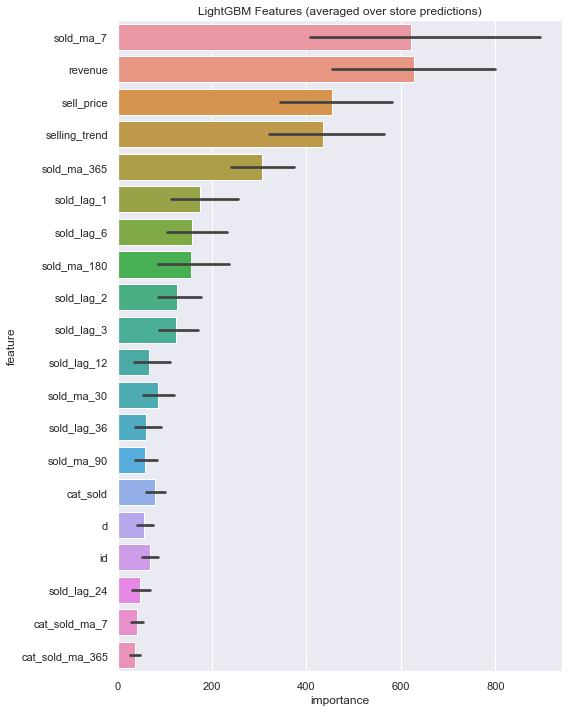

In [38]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('../saved/model/'):
    if 'model' in filename:
        # load model
        model = joblib.load(os.path.join('../saved/model/', filename))
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)